## SMA Strategy

Let’s start off with a Simple Moving Average (SMA) strategy. We will start with a simple version of the strategy, namely:

Select the securities that are currently above their 50 day moving average
Weigh each selected security equally
Rebalance the portfolio to reflect the target weights
This should be pretty simple to build. The only thing missing above is the calculation of the simple moving average. When should this take place?

Given the flexibility of bt, there is no strict rule. The average calculation could be performed in an Algo, but that would be pretty inefficient. A better way would be to calculate the moving average at the beginning - before starting the backtest. After all, all the data is known in advance.

Now that we know what we have to do, let’s get started. First we will download some data and calculate the simple moving average.

In [1]:
import bt
import pandas as pd
%matplotlib inline

# data = bt.get('SPTL,ACWI,SCHP,EEM,IAU,GSG,VWOB,XLRE,HYLB', start='2005-01-01')
start_dt='2018-01-01'
data = bt.get('frel,sptl,voog,vwob,iauf,zbh', start=start_dt)
data.head()

,frel,sptl,voog,vwob,iau,zbh
Date,,,,,,
2018-01-02,22.220995,34.132061,134.382233,72.488449,12.67,121.795738
2018-01-03,22.184845,34.273701,135.441360,72.560577,12.64,122.640053
2018-01-04,21.832418,34.273701,135.966049,72.569588,12.71,122.463341
2018-01-05,21.841459,34.160389,137.229233,72.668755,12.69,123.680717
2018-01-08,21.986042,34.150948,137.627594,72.497452,12.69,123.916328


It’s always a good idea to plot your data to make sure it looks ok. So let’s see how the data + sma plot looks like.



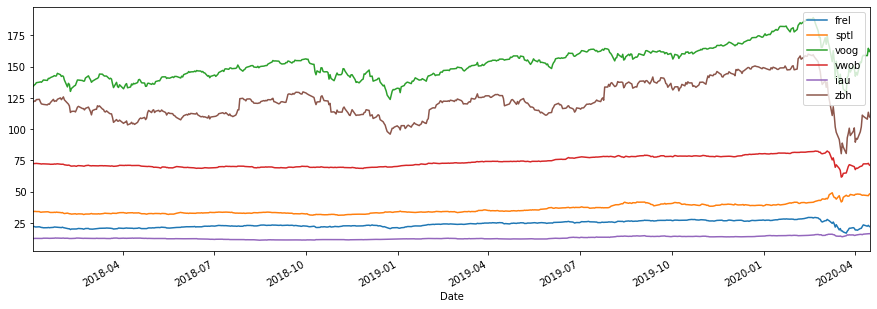

In [2]:
# let's see what the data looks like - this is by no means a pretty chart, but it does the job
plot = data.plot(figsize=(15, 5))

# Growth strategies

My “library” of backtests, you might want to write yourself a helper function that would allow you to test different parameters and securities.

In [3]:
strategy = bt.Strategy('example', [bt.algos.SelectAll(),
                                    bt.algos.WeighInvVol(),
                                   bt.algos.Rebalance()])                         
                                   
bt_gross = bt.Backtest(strategy, data, integer_positions=False,
                       commissions=lambda q, p: 0, name='gross')
bt_net = bt.Backtest(strategy, data, integer_positions=False,
                     commissions=lambda q, p: abs(q) * p * 0.33, name='net')

res_gross = bt.run(bt_gross)
pdf_gross = bt.merge(res_gross.get_transactions('gross')) 
# df_merge = bt.merge(result.get_transactions('gross'), result.get_transactions('net')) 

gross
0% [############################# ] 100% | ETA: 00:00:00

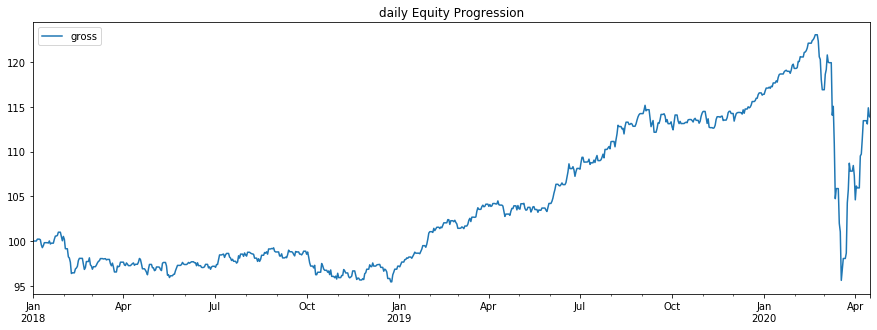

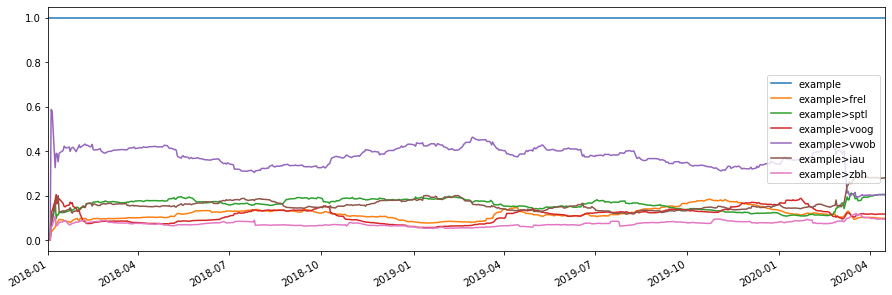

In [4]:
res_gross.plot(freq='d')
res_gross.plot_weights()

In [8]:
res_gross.get_security_weights().tail(1).T.sort_values(by='2020-04-16',ascending=False)

,2020-04-16
iau,0.279829
vwob,0.205037
sptl,0.204857
voog,0.117493
frel,0.098290
zbh,0.094494


# Moving Average Crossover Strategy
Let’s build on the last section to test a moving average crossover strategy. The easiest way to achieve this is to build an Algo similar to SelectWhere, but for the purpose of setting target weights. Let’s call this algo WeighTarget. This algo will take a DataFrame of target weights that we will pre-calculate.

Basically, when the 50 day moving average will be above the 200-day moving average, we will be long (+1 target weight). Conversely, when the 50 is below the 200, we will be short (-1 target weight).

Here’s the WeighTarget implementation (this Algo also already exists in the algos module):

In [ ]:
class WeighTarget(bt.Algo):
    """
    Sets target weights based on a target weight DataFrame.

    Args:
        * target_weights (DataFrame): DataFrame containing the target weights

    Sets:
        * weights

    """

    def __init__(self, target_weights):
        self.tw = target_weights

    def __call__(self, target):
        # get target weights on date target.now
        if target.now in self.tw.index:
            w = self.tw.ix[target.now]

            # save in temp - this will be used by the weighing algo
            # also dropping any na's just in case they pop up
            target.temp['weights'] = w.dropna()

        # return True because we want to keep on moving down the stack
        return True
    

In [ ]:
# first let's create a helper function to create a ma cross backtest
def ma_cross(ticker, start='2016-01-01',
             short_ma=50, long_ma=200, name='ma_cross'):
    # these are all the same steps as above
    data = bt.get(ticker, start=start)
    short_sma = data.rolling(short_ma).mean()
    long_sma  = data.rolling(long_ma).mean()

    # target weights
    tw = long_sma.copy()
    tw[short_sma > long_sma] = 1.0
    tw[short_sma <= long_sma] = -1.0
    tw[long_sma.isnull()] = 0.0

    # here we specify the children (3rd) arguemnt to make sure the strategy
    # has the proper universe. This is necessary in strategies of strategies
    s = bt.Strategy(name, [WeighTarget(tw), bt.algos.Rebalance()], [ticker])

    return bt.Backtest(s, data)

In [ ]:
# ok now let's create a few backtests and gather the results.
# these will later become our "synthetic securities"

t1 = ma_cross('frel', name='frel_ma_cross',start=start_dt)
t2 = ma_cross('sptl', name='sptl_ma_cross',start=start_dt)
t3 = ma_cross('voog', name='voog_ma_cross',start=start_dt)
t4 = ma_cross('vwob', name='vwob_ma_cross',start=start_dt)
t5 = ma_cross('iau', name='iau_ma_cross',start=start_dt)
t6 = ma_cross('zbh', name='zbh_ma_cross',start=start_dt)
# t6 = ma_cross('zbh', name='zbh_ma_cross',start=start_dt)


# let's run these strategies now
res = bt.run(t1, t2, t3, t4, t5,t6)

# now that we have run the strategies, let's extract
# the data to create "synthetic securities"
data = bt.merge(res['frel_ma_cross'].prices, res['sptl_ma_cross'].prices,
               res['voog_ma_cross'].prices,res['vwob_ma_cross'].prices,
                res['iau_ma_cross'].prices,res['zbh_ma_cross'].prices,
               )

# now we have our new data. This data is basically the equity
# curves of both backtested strategies. Now we can just use this
# to test any old strategy, just like before.
stragety_crossover = bt.Strategy('crossover', [bt.algos.SelectAll(),
                      bt.algos.WeighInvVol(),
                      bt.algos.Rebalance()])

# create and run
bt_crossover = bt.Backtest(stragety_crossover, data)
# res = bt.run(t)

res_crossover = bt.run(bt_crossover)
pdf_crossover = bt.merge(res_crossover.get_transactions('crossover')) 

In [ ]:
res_crossover.plot(freq='d')
res_crossover.plot_weights()

So let’s start with a simple 50-200 day sma crossover for a single security.
Ok so we downloaded our data, calculated the simple moving averages, and then we setup our target weight (tw) DataFrame. Let’s take a look at our target weights to see if they make any sense.

In [ ]:
res_crossover.get_security_weights().tail(1).T.sort_values(by='2020-04-15',ascending=False)